In [1]:
from torch.utils.data import Dataset
import os
import logging
import traceback
import shutil
import zipfile
import random
import re
import numpy as np
import contextlib
import mne

In [2]:
import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

### Downloading the dataset

In [ ]:
dataset_path = os.path.join('data', 'openfmri')
default_download_urls = [  # Links to normalized data of all participants
    # "https://s3.amazonaws.com/openneuro/ds000117/ds000117_R1.0.0/compressed/ds000117_R1.0.0_derivatives_sub01-04.zip",
    # "https://s3.amazonaws.com/openneuro/ds000117/ds000117_R1.0.0/compressed/ds000117_R1.0.0_derivatives_sub05-08.zip",
    # "https://s3.amazonaws.com/openneuro/ds000117/ds000117_R1.0.0/compressed/ds000117_R1.0.0_derivatives_sub09-12.zip",
    # "https://s3.amazonaws.com/openneuro/ds000117/ds000117_R1.0.0/compressed/ds000117_R1.0.0_derivatives_sub13-16.zip"
]

def download_dataset(dataset_path, download_urls):
    """
    Downloads the dataset from the specified URLs to the given dataset path.

    Parameters:
        dataset_path (str): The directory path where the dataset will be downloaded.
        download_urls (list): A list of URLs from which to download the dataset.

    Returns:
        None
    """
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    
    downloaded_marker = os.path.join(dataset_path, '.downloaded')
    
    if not os.path.exists(downloaded_marker):
        logger.info(f"Downloading {len(download_urls)} files...")
        for url in download_urls:
            file_name = os.path.join(dataset_path, url.split('/')[-1])
            if not os.path.exists(file_name):
                logger.info(f"Downloading {file_name}...")
                try:
                    os.system(f"wget -O {file_name} {url}")
                except Exception as e:
                    logger.error(f"Error downloading file {file_name}, {e}")
                    traceback.print_exc()
            else:
                logger.info(f"{file_name} already exists, skipping download.")
        
        # Check if all files are downloaded
        downloaded_files = [f for f in os.listdir(dataset_path) if f.endswith('.zip')]
        if len(downloaded_files) == len(download_urls):
            with open(downloaded_marker, 'w') as f:
                f.write('Download completed successfully.')
            logger.info(f"Successfully downloaded {len(downloaded_files)} files.")
    else:
        logger.info("Dataset already downloaded. Skipping download.")

In [ ]:
# download_dataset(dataset_path, default_download_urls)

### Unzipping & Renaming the dataset

In [21]:
from tqdm import tqdm

def unzip_and_rename_in_folder(folder, remove=False):
    """
    Unzips all zip files in the specified folder and renames the extracted folders.

    Parameters:
        folder (str): The path to the folder containing zip files to be unzipped.
        remove (bool): If True, the zip files will be deleted after extraction.

    Returns:
        None
    """
    unzipped_marker = os.path.join(folder, '.unzipped')
    if os.path.exists(unzipped_marker):
        logger.info(f"Folder {folder} is already unzipped. Exiting early.")
        return

    assert all(f.endswith('.zip') or f.startswith('.') for f in os.listdir(folder)), (
        f"Not all files in {folder} are zip files or ignored files. Please delete non-zip files and re-run."
    )
    zip_file_count = sum(1 for f in os.listdir(folder) if f.endswith('.zip'))
    logger.info(f"Unzipping and renaming {zip_file_count} files in folder: {folder}")
    
    # Add a progress bar for unzipping
    with tqdm(total=zip_file_count, desc="Unzipping files", unit="file") as pbar:
        for zip_file in os.listdir(folder):
            zip_file_path = os.path.join(folder, zip_file)
            if zip_file.endswith('.zip'):
                logger.info(f"Unzipping {zip_file_path}...")
                try:
                    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                        zip_ref.extractall(os.path.dirname(zip_file_path))
                    if remove:
                        os.remove(zip_file_path)  # Remove the zip file after extraction
                        logger.info(f"Unzipped and removed {zip_file_path}")
                    else:
                        logger.info(f"Unzipped {zip_file_path}")
                except Exception as e:
                    logger.error(f"Error unzipping {zip_file_path}, {e}")
                    traceback.print_exc()
                pbar.update(1)  # Update the progress bar

    for i, unzipped_folder in enumerate(
        f for f in os.listdir(folder) if not f.endswith('.zip') and not f.startswith('.')
    ):
        from_name = os.path.join(folder, unzipped_folder)
        to_name = os.path.join(folder, f'folder_{i}')
        os.rename(from_name, to_name)

    # Create the .unzipped marker file
    with open(unzipped_marker, 'w') as marker_file:
        marker_file.write('')

In [23]:
unzip_and_rename_in_folder(dataset_path)

INFO:__main__:Unzipping and renaming 1 files in folder: data/openfmri
Unzipping files:   0%|          | 0/1 [00:00<?, ?file/s]INFO:__main__:Unzipping data/openfmri/ds000117_R1.0.0_derivatives_sub05-08.zip...
INFO:__main__:Unzipped data/openfmri/ds000117_R1.0.0_derivatives_sub05-08.zip
Unzipping files: 100%|██████████| 1/1 [02:00<00:00, 120.68s/file]


### Arranging folders

In [32]:
def arrange_folders(dataset_folder):
    """
    Rearranges the files in the dataset folder after downloading and unzipping.

    This function organizes the dataset by moving participant folders into the main dataset folder,
    extracting the necessary files, and cleaning up unnecessary directories.

    Parameters:
        dataset_folder (str): The path to the main dataset folder.

    Returns:
        None
    """
    arranged_marker = os.path.join(dataset_folder, '.arranged')
    if os.path.exists(arranged_marker):
        logger.info(f"Dataset folder {dataset_folder} is already arranged. Exiting early.")
        return

    # Step 1: Move participant folders from 'folder_0/derivatives/meg_derivatives' to 'dataset_folder'
    source_folder = os.path.join(dataset_folder, 'folder_0', 'derivatives', 'meg_derivatives')
    if not os.path.exists(source_folder):
        logger.error(f"Source folder {source_folder} does not exist.")
        return

    participant_folders = [
        f for f in os.listdir(source_folder)
        if os.path.isdir(os.path.join(source_folder, f))
        and f.startswith('sub-')  # Assuming participant folders start with 'sub-'
    ]

    # Move participant folders to dataset_folder
    for participant_folder in participant_folders:
        source = os.path.join(source_folder, participant_folder)
        destination = os.path.join(dataset_folder, participant_folder)
        if os.path.exists(destination):
            logger.warning(f"Destination folder {destination} already exists. Skipping.")
        else:
            shutil.move(source, dataset_folder)
            logger.info(f"Moved {source} to {dataset_folder}.")

    # Step 2: For each participant, move files from 'ses-meg/meg/' to participant folder and delete subfolders
    participant_folders = [
        f for f in os.listdir(dataset_folder)
        if os.path.isdir(os.path.join(dataset_folder, f))
        and f.startswith('sub-')
    ]

    for participant_folder in participant_folders:
        participant_folder_path = os.path.join(dataset_folder, participant_folder)
        source_subfolder = os.path.join(participant_folder_path, 'ses-meg', 'meg')
        if not os.path.exists(source_subfolder):
            logger.warning(f"Expected directory {source_subfolder} does not exist. Skipping.")
            continue

        # Move contents of 'ses-meg/meg' to participant folder
        move_contents_to_parent_and_delete_sub(
            source_subfolder,
            participant_folder_path,
            delete_empty_parent_dirs=True  # New parameter to delete empty parent directories
        )

    # Step 3: Remove unnecessary folders
    folder_0_path = os.path.join(dataset_folder, 'folder_0')
    if os.path.exists(folder_0_path):
        shutil.rmtree(folder_0_path)
        logger.info(f"Removed unnecessary folder {folder_0_path}.")

    # Create the .arranged marker file
    with open(arranged_marker, 'w') as marker_file:
        marker_file.write('')

    logger.info("Arrangement of folders completed successfully.")


def move_contents_to_parent_and_delete_sub(source_folder, destination_folder, delete_empty_parent_dirs=False):
    """
    Moves all contents from the source folder to the destination folder and deletes the source folder.
    Optionally deletes any empty parent directories of the source folder.

    Parameters:
        source_folder (str): The absolute path of the source folder whose contents are to be moved.
        destination_folder (str): The absolute path to the destination folder where contents will be moved.
        delete_empty_parent_dirs (bool): If True, delete empty parent directories after moving contents.

    Returns:
        None
    """
    if not os.path.exists(source_folder):
        logger.warning(f"Source folder {source_folder} does not exist. Skipping.")
        return

    # Move contents of source_folder to destination_folder
    for item in os.listdir(source_folder):
        source_item = os.path.join(source_folder, item)
        destination_item = os.path.join(destination_folder, item)
        if os.path.exists(destination_item):
            logger.warning(f"Destination item {destination_item} already exists. Skipping.")
            continue
        shutil.move(source_item, destination_folder)
        logger.info(f"Moved {source_item} to {destination_folder}.")

    # Delete the source folder
    shutil.rmtree(source_folder)
    logger.info(f"Removed folder {source_folder}.")

    # Optionally delete empty parent directories
    if delete_empty_parent_dirs:
        current_path = os.path.dirname(source_folder)
        while current_path != destination_folder:
            if not os.listdir(current_path):
                os.rmdir(current_path)
                logger.info(f"Removed empty parent directory {current_path}.")
                current_path = os.path.dirname(current_path)
            else:
                break

In [ ]:
arrange_folders(dataset_path)

In [ ]:
def rename_dataset_files(dataset_path):
    """
    Renames all files in the dataset according to specified pattern.
    
    For each participant folder (sub-XX), it finds files matching the pattern:
    'sub-XX_ses-meg_task-facerecognition_run-YY_proc-tsss_meg.fif' or '.txt'
    and renames them to 'run_YY.fif' or 'run_YY.txt'.

    Parameters:
        dataset_path (str): The path to the dataset folder containing participant folders.

    Returns:
        None
    """
    # Get all participant folders (directories starting with 'sub-')
    participant_folders = [
        f for f in os.listdir(dataset_path)
        if os.path.isdir(os.path.join(dataset_path, f)) and f.startswith('sub-')
    ]

    for participant_folder in participant_folders:
        participant_path = os.path.join(dataset_path, participant_folder)
        
        # Process each file in the participant folder
        for file_name in os.listdir(participant_path):
            # Match the pattern for .fif and .txt files
            match = re.match(
                r'^sub-\d+_ses-meg_task-facerecognition_run-(\d{2})_proc-tsss_(meg|log)\.(fif|txt)$',
                file_name
            )
            
            if match:
                run_number = match.group(1)
                file_type = match.group(2)
                extension = match.group(3)
                
                # Determine new filename based on file type
                if file_type == 'meg':
                    new_file_name = f'run_{run_number}.fif'
                elif file_type == 'log':
                    new_file_name = f'run_{run_number}.txt'
                else:
                    continue
                
                # Create full paths for source and destination
                source = os.path.join(participant_path, file_name)
                destination = os.path.join(participant_path, new_file_name)
                
                # Rename file if destination doesn't exist
                if os.path.exists(destination):
                    logger.warning(f"Destination file {destination} already exists. Skipping renaming of {source}.")
                    continue
                    
                try:
                    os.rename(source, destination)
                    logger.info(f"Renamed {source} to {destination}.")
                except Exception as e:
                    logger.error(f"Failed to rename {source} to {destination}: {e}")
            else:
                logger.debug(f"File {file_name} does not match the expected pattern. Skipping.")

In [ ]:
rename_dataset_files(dataset_path)

### Randomize data

In [38]:
def randomize_subject_data(dataset_folder, train_percentage=70, val_percentage=20):
    """
    Randomizes and splits participant data into training, validation, and test sets.

    Parameters:
        dataset_folder (str): The path to the main dataset folder.
        train_percentage (int): The percentage of data allocated to the training set.
        val_percentage (int): The percentage of data allocated to the validation set.

    Returns:
        None
    """
    participant_folders = [
        f for f in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, f))
    ]
    random.seed(42)
    random.shuffle(participant_folders)

    total_participants = len(participant_folders)
    train_count = int(total_participants * train_percentage / 100)
    val_count = int(total_participants * val_percentage / 100)

    train_folder = os.path.join(dataset_folder, 'train')
    val_folder = os.path.join(dataset_folder, 'val')
    test_folder = os.path.join(dataset_folder, 'test')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    for i, participant_folder in enumerate(participant_folders):
        participant_folder_path = os.path.join(dataset_folder, participant_folder)
        if i < train_count:
            shutil.move(participant_folder_path, train_folder)
        elif i < train_count + val_count:
            shutil.move(participant_folder_path, val_folder)
        else:
            shutil.move(participant_folder_path, test_folder)

In [39]:
randomize_subject_data(dataset_path, train_percentage=70, val_percentage=20)
# Might need a manual re-shuffling after, if no subject folders are in the val or train or test dir after you run this function.

### Count data set Frames
- To ensure each file has matching eeg & MEG frame count. 

In [46]:
def count_frames(dataset_path, mode='train'):
    """
    Counts the number of frames in the dataset and returns the frame count.

    Parameters:
        dataset_path (str): The path to the main dataset folder.
        mode (str): The dataset mode ('train', 'val', or 'test').

    Returns:
        tuple: (frame_count, eeg_channel_count, meg_channel_count)
    """
    mode_path = os.path.join(dataset_path, mode)
    frame_count_file = os.path.join(mode_path, '.frameCount')

    if os.path.exists(frame_count_file):
        with open(frame_count_file, 'r') as f:
            frame_count = int(f.read().strip())
        logger.info(f"Loaded cached frame count: {frame_count}")
    else:
        eeg_frame_count = 0
        meg_frame_count = 0
        eeg_channels = 0
        meg_channels = 0

        participant_folders = [
            f for f in os.listdir(mode_path)
            if not f.startswith('.') and not f.endswith('.zip') and os.path.isdir(os.path.join(mode_path, f))
        ]
        
        logger.info(f"Counting frames in {mode} dataset...")
        for participant_folder in participant_folders:
            fif_files = [
                file for file in os.listdir(os.path.join(mode_path, participant_folder))
                if file.endswith('.fif')
            ]
            for fif in fif_files:
                fif_path = os.path.join(mode_path, participant_folder, fif)
                try:
                    with contextlib.redirect_stdout(None), contextlib.redirect_stderr(None):
                        raw_data = mne.io.read_raw_fif(fif_path, preload=False, verbose=False)
                except Exception as e:
                    logger.error(f"Error reading {fif_path}, {e}")
                    raise e
                eeg_data = raw_data.get_data(picks='eeg')
                meg_data = raw_data.get_data(picks='meg')
                eeg_frame_count += eeg_data.shape[1]
                meg_frame_count += meg_data.shape[1]
                eeg_channels = eeg_data.shape[0]
                meg_channels = meg_data.shape[0]
        assert eeg_frame_count == meg_frame_count, "EEG and MEG frame count not equal."
        frame_count = eeg_frame_count
        logger.info(f"Successfully counted {frame_count} frames in {mode} dataset...")

        with open(frame_count_file, 'w') as f:
            f.write(str(frame_count))

    return frame_count, eeg_channels, meg_channels

### Previewing the data
- To understand what we are working with

In [52]:
import mne
import numpy as np
from pprint import pprint
from collections import Counter

# Replace with the path to your .fif file
fif_file = 'data/openfmri/train/sub-05/run_01.fif'

# Read the raw data with preloading
raw = mne.io.read_raw_fif(fif_file, preload=True)
print(raw)

Opening raw data file data/openfmri/train/sub-05/run_01.fif...
    Range : 141900 ... 681999 =    129.000 ...   619.999 secs
Ready.
Reading 0 ... 540099  =      0.000 ...   490.999 secs...


/tmp/ipykernel_1410071/491012473.py:10: RuntimeWarning: This filename (data/openfmri/train/sub-05/run_01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


<Raw | run_01.fif, 404 x 540100 (491.0 s), ~1.63 GB, data loaded>


In [56]:
n_channels = raw.info['nchan']
print(f'Number of channels: {n_channels}')

Number of channels: 404


In [54]:
channel_names = raw.ch_names
print(f'Channel names ({len(channel_names)}): {channel_names}')

Channel names (404): ['MEG0113', 'MEG0112', 'MEG0111', 'MEG0122', 'MEG0123', 'MEG0121', 'MEG0132', 'MEG0133', 'MEG0131', 'MEG0143', 'MEG0142', 'MEG0141', 'MEG0213', 'MEG0212', 'MEG0211', 'MEG0222', 'MEG0223', 'MEG0221', 'MEG0232', 'MEG0233', 'MEG0231', 'MEG0243', 'MEG0242', 'MEG0241', 'MEG0313', 'MEG0312', 'MEG0311', 'MEG0322', 'MEG0323', 'MEG0321', 'MEG0333', 'MEG0332', 'MEG0331', 'MEG0343', 'MEG0342', 'MEG0341', 'MEG0413', 'MEG0412', 'MEG0411', 'MEG0422', 'MEG0423', 'MEG0421', 'MEG0432', 'MEG0433', 'MEG0431', 'MEG0443', 'MEG0442', 'MEG0441', 'MEG0513', 'MEG0512', 'MEG0511', 'MEG0523', 'MEG0522', 'MEG0521', 'MEG0532', 'MEG0533', 'MEG0531', 'MEG0542', 'MEG0543', 'MEG0541', 'MEG0613', 'MEG0612', 'MEG0611', 'MEG0622', 'MEG0623', 'MEG0621', 'MEG0633', 'MEG0632', 'MEG0631', 'MEG0642', 'MEG0643', 'MEG0641', 'MEG0713', 'MEG0712', 'MEG0711', 'MEG0723', 'MEG0722', 'MEG0721', 'MEG0733', 'MEG0732', 'MEG0731', 'MEG0743', 'MEG0742', 'MEG0741', 'MEG0813', 'MEG0812', 'MEG0811', 'MEG0822', 'MEG0823',

In [57]:
channel_types = raw.get_channel_types()
type_counts = Counter(channel_types)
print(f'Channel types and counts: {type_counts}')

Channel types and counts: Counter({'grad': 204, 'mag': 102, 'eeg': 74, 'misc': 12, 'chpi': 9, 'stim': 3})


### Manipulating the dataset
- How to:

In [58]:

# Get indices of EEG channels
eeg_indices = mne.pick_types(raw.info, meg=False, eeg=True)
print(f'EEG channel indices: {eeg_indices}')
print(f'Number of EEG channels: {len(eeg_indices)}')

# Get indices of MEG channels
meg_indices = mne.pick_types(raw.info, meg=True, eeg=False)
print(f'MEG channel indices: {meg_indices}')
print(f'Number of MEG channels: {len(meg_indices)}')

# Optional: Separate MEG magnetometers and gradiometers
mag_indices = mne.pick_types(raw.info, meg='mag')
grad_indices = mne.pick_types(raw.info, meg='grad')
print(f'Number of magnetometer channels: {len(mag_indices)}')
print(f'Number of gradiometer channels: {len(grad_indices)}')

EEG channel indices: [306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379]
Number of EEG channels: 74
MEG channel indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 

Opening raw data file data/openfmri/train/sub-05/run_01.fif...
    Range : 141900 ... 681999 =    129.000 ...   619.999 secs
Ready.
<Raw | run_01.fif, 404 x 540100 (491.0 s), ~7.0 MB, data not loaded>
Channel names: ['MEG0113', 'MEG0112', 'MEG0111', 'MEG0122', 'MEG0123', 'MEG0121', 'MEG0132', 'MEG0133', 'MEG0131', 'MEG0143', 'MEG0142', 'MEG0141', 'MEG0213', 'MEG0212', 'MEG0211', 'MEG0222', 'MEG0223', 'MEG0221', 'MEG0232', 'MEG0233', 'MEG0231', 'MEG0243', 'MEG0242', 'MEG0241', 'MEG0313', 'MEG0312', 'MEG0311', 'MEG0322', 'MEG0323', 'MEG0321', 'MEG0333', 'MEG0332', 'MEG0331', 'MEG0343', 'MEG0342', 'MEG0341', 'MEG0413', 'MEG0412', 'MEG0411', 'MEG0422', 'MEG0423', 'MEG0421', 'MEG0432', 'MEG0433', 'MEG0431', 'MEG0443', 'MEG0442', 'MEG0441', 'MEG0513', 'MEG0512', 'MEG0511', 'MEG0523', 'MEG0522', 'MEG0521', 'MEG0532', 'MEG0533', 'MEG0531', 'MEG0542', 'MEG0543', 'MEG0541', 'MEG0613', 'MEG0612', 'MEG0611', 'MEG0622', 'MEG0623', 'MEG0621', 'MEG0633', 'MEG0632', 'MEG0631', 'MEG0642', 'MEG0643', 'M

/tmp/ipykernel_1410071/276621127.py:7: RuntimeWarning: This filename (data/openfmri/train/sub-05/run_01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=False)
/tmp/ipykernel_1410071/276621127.py:19: RuntimeWarning: Only 10 head digitization points of the specified kind ("extra",), fitting may be inaccurate
  raw.plot_sensors(kind='topomap', show_names=False)
/tmp/ipykernel_1410071/276621127.py:19: RuntimeWarning: (X, Y) fit (-1.6, 40.5) more than 20 mm from head frame origin
  raw.plot_sensors(kind='topomap', show_names=False)


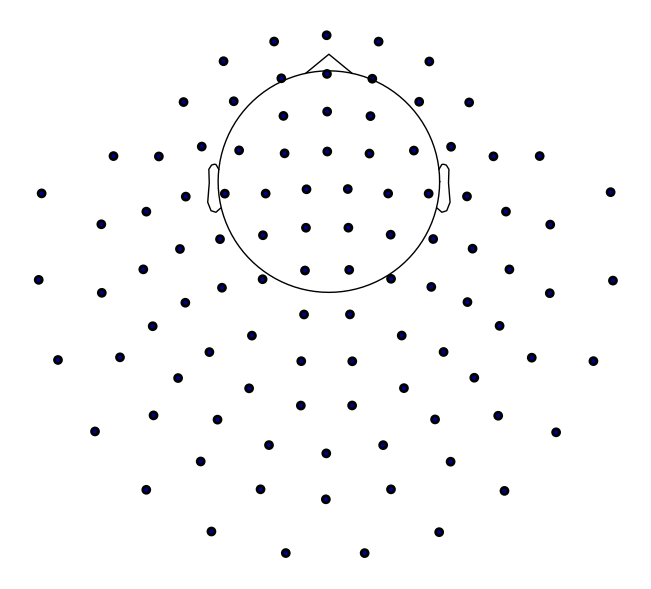

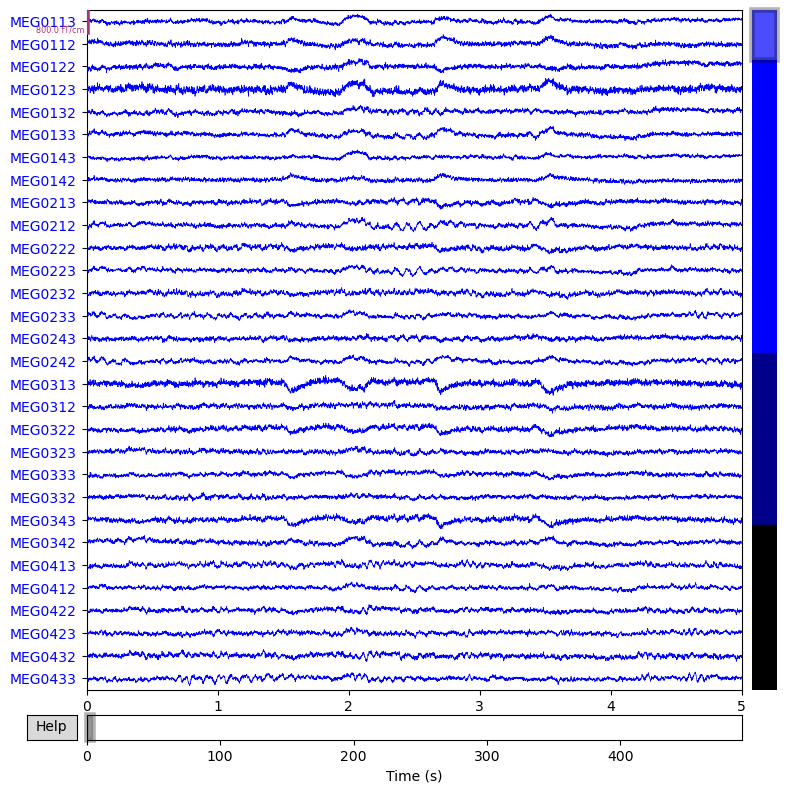

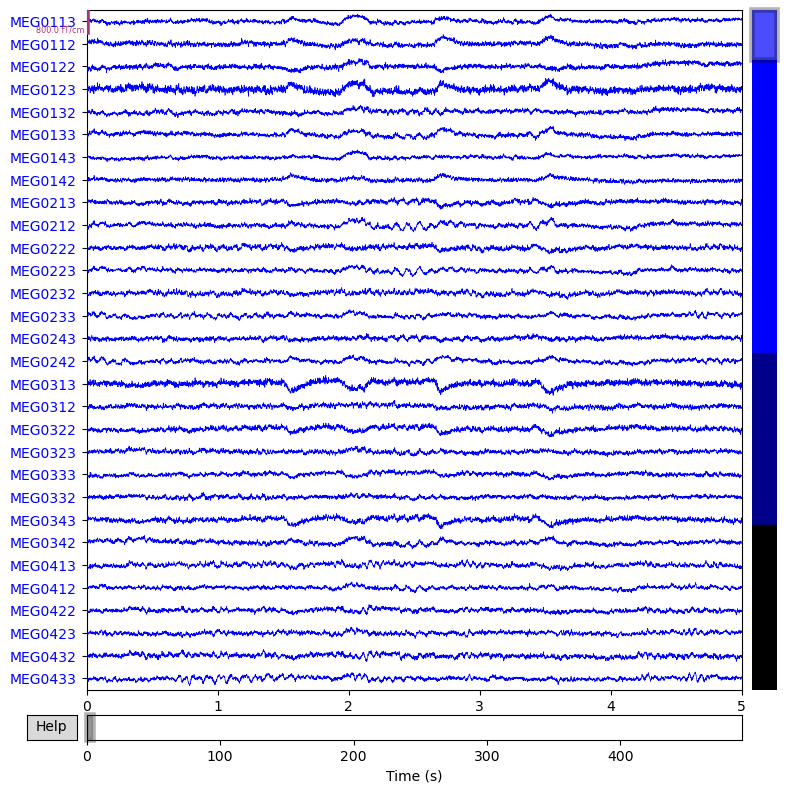

In [55]:
import mne

# Replace with the path to your .fif file
fif_file = 'data/openfmri/train/sub-05/run_01.fif'

# Read the raw data
raw = mne.io.read_raw_fif(fif_file, preload=False)

# Print a summary of the data
print(raw)

# List all channel names
print(f'Channel names: {raw.ch_names}')

# Get information about the channel types
print(f'Channel types: {set(raw.get_channel_types())}')

# Plot the sensor locations
raw.plot_sensors(kind='topomap', show_names=False)

# Plot a short segment of data
raw.plot(duration=5, n_channels=30)

In [47]:
frame_count, eeg_channel_count, meg_channel_count = count_frames(dataset_path, mode='train')
logger.info(f"Frame Count: {frame_count}")
logger.info(f"EEG Channel Count: {eeg_channel_count}")
logger.info(f"MEG Channel Count: {meg_channel_count}")

INFO:__main__:Counting frames in train dataset...


ValueError: buffer size must be a multiple of element size

In [42]:
### Debugging frame counting
import mne
import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

fif_path = 'data/openfmri/train/sub-07/run_02.fif'
logger.debug(f"Attempting to read {fif_path}")

try:
    raw_data = mne.io.read_raw_fif(fif_path, preload=True, verbose=True)
    logger.debug(f"Successfully read {fif_path}")
    logger.debug(f"raw_data.info['nchan']: {raw_data.info['nchan']}")
    logger.debug(f"raw_data.info['ch_names']: {raw_data.info['ch_names']}")
    logger.debug(f"raw_data.info['sfreq']: {raw_data.info['sfreq']}")
    logger.debug(f"Number of time points (samples): {raw_data.n_times}")

    eeg_picks = mne.pick_types(raw_data.info, eeg=True, meg=False)
    logger.debug(f"EEG Picks indices: {eeg_picks}")
    logger.debug(f"Number of EEG channels: {len(eeg_picks)}")

    eeg_data = raw_data.get_data(picks=eeg_picks)
    logger.debug(f"EEG data shape: {eeg_data.shape}")
except Exception as e:
    logger.error(f"Error processing {fif_path}: {e}")
    logger.exception(e)

DEBUG:__main__:Attempting to read data/openfmri/train/sub-07/run_02.fif


Opening raw data file data/openfmri/train/sub-07/run_02.fif...


/tmp/ipykernel_1410071/2667062107.py:12: RuntimeWarning: This filename (data/openfmri/train/sub-07/run_02.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_data = mne.io.read_raw_fif(fif_path, preload=True, verbose=True)
ERROR:__main__:Error processing data/openfmri/train/sub-07/run_02.fif: fname does not exist: "/home/azureuser/Lemonai/gleb/Synaptech/data_magic/data/openfmri/train/sub-07/run_02.fif"
ERROR:__main__:fname does not exist: "/home/azureuser/Lemonai/gleb/Synaptech/data_magic/data/openfmri/train/sub-07/run_02.fif"
Traceback (most recent call last):
  File "/tmp/ipykernel_1410071/2667062107.py", line 12, in <module>
    raw_data = mne.io.read_raw_fif(fif_path, preload=True, verbose=True)
  File "/home/azureuser/miniconda3/envs/synaptech_env/lib/python3.10/site-packages/mne/io/fiff/raw.py", l

In [8]:
def calculate_chunk_number(frame_count, eeg_channel_count, meg_channel_count,
                           memory_limit='32', vram_limit='16',
                           memory_chunk_size='4', vram_chunk_size='8',
                           eeg_values_type=np.float16, meg_values_type=np.float16):
    """
    Calculates and logs the number of chunks for memory and VRAM usage.

    Parameters:
        frame_count (int): Total number of frames.
        eeg_channel_count (int): Number of EEG channels.
        meg_channel_count (int): Number of MEG channels.
        memory_limit (str): Memory limit in GB.
        vram_limit (str): VRAM limit in GB.
        memory_chunk_size (str): Memory chunk size in GB.
        vram_chunk_size (str): VRAM chunk size in GB.
        eeg_values_type (dtype): Data type for EEG values.
        meg_values_type (dtype): Data type for MEG values.

    Returns:
        None
    """
    logger.info("Calculating chunk sizes...")
    eeg_value_type_size = np.dtype(eeg_values_type).itemsize
    total_eeg_size = eeg_channel_count * frame_count * eeg_value_type_size

    meg_value_type_size = np.dtype(meg_values_type).itemsize
    total_meg_size = meg_channel_count * frame_count * meg_value_type_size

    total_size = total_eeg_size + total_meg_size
    
    logger.info(f"Size of EEG and MEG data in dataset: {total_size / (1024**3):.2f} GB")

    memory_chunk_size_bytes = int(memory_chunk_size) * (1024 ** 3)
    vram_chunk_size_bytes = int(vram_chunk_size) * (1024 ** 3)

    memory_chunk_number = total_size // memory_chunk_size_bytes
    vram_chunk_number = total_size // vram_chunk_size_bytes

    logger.info(f"Memory Chunk Number: {memory_chunk_number}")
    logger.info(f"VRAM Chunk Number: {vram_chunk_number}")

In [62]:
# Calculate Chunk Number
calculate_chunk_number(
    frame_count,
    eeg_channel_count,
    meg_channel_count,
    memory_limit='32',
    vram_limit='16',
    memory_chunk_size='4',
    vram_chunk_size='8',
    eeg_values_type=np.float16,
    meg_values_type=np.float16
)

INFO:__main__:Calculating chunk sizes...
INFO:__main__:Size of EEG and MEG data in dataset: 4.28 GB
INFO:__main__:Memory Chunk Number: 1
INFO:__main__:VRAM Chunk Number: 0
